# Analysis of Vehicle Telematics for Time Spent during Passenger Pick up and Drop off. 

## INTRODUCTION
The aim of this project is to gain insignt on the duration of time MOIA vehicles stop when picking up and dropping off customers. The anlysis involves determining how much this duration is influenced by the number of passengers picked or dropped off.

## Reading the data
The first step will be to import the two data sets provided after the neccessary libraries have been imported.

In [1]:
# Import the neccesary libraries
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# If seaborn and datetime are not installed, please uncomment the code below
# pip install seaborn
# pip install DateTime

### Request data
The request data contains pickup time and dropoff time for each request and also the number of passengers as well as the vehicle id.

In [3]:
# import request data
requests = pd.read_csv("data/requests.csv")
requests.head()

,Unnamed: 0,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,vehicle_id,num_passengers
0,0,532d0e16-c098-4b,2020-02-12 22:47:34.456993103,2020-02-12 23:05:19.257940583,vehicle_8d80,2
1,1,6733c7b7-cd8d-4b,2020-02-13 01:24:45.285655499,2020-02-13 01:36:26.522647319,vehicle_cd00,2
2,2,12895eca-a8bb-41,2020-02-12 16:15:33.002158642,2020-02-12 16:21:24.103677982,vehicle_1e43,2
3,3,379588c2-a219-47,2020-02-13 01:53:04.029590845,2020-02-13 02:17:04.471062925,vehicle_e136,1
4,4,ad1fcd0c-ef5b-46,2020-02-12 05:58:21.626791000,2020-02-12 06:11:04.797907300,vehicle_42c0,1


### Door Events
The door events data consists of the door opening and closing events including the type of door (passsenger/driver).

In [4]:
# read the data
door_events = pd.read_csv("data/door_events.csv")
print(door_events["door_name"].unique())
door_events.head()

['passenger' 'driver']


,Unnamed: 0,vehicle_id,door_state,timestamp_utc,door_name
0,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger
1,1,vehicle_8d80,close,2020-02-12 05:44:29.130999430,passenger
2,2,vehicle_1e43,open,2020-02-12 11:22:15.486912267,passenger
3,3,vehicle_e136,closing,2020-02-12 22:02:13.275264985,passenger
4,4,vehicle_f653,open,2020-02-12 11:49:54.222489477,passenger


## Data Preprocessing
The first approach will be to map the pick up and drop off time with individual requests to obtain the time spent for the request. To do this, I will need to convert the time in both dataframes to datetime and additionally sort the door events by door state and time.

In [5]:
# for requests
for i in range(len(requests)):
    # removing the extra decimal seconds
    requests["pickup_timestamp_utc"][i] =  requests["pickup_timestamp_utc"][i][:-10]
    requests["dropoff_timestamp_utc"][i] =  requests["dropoff_timestamp_utc"][i][:-10]
    
    # Convert to datetime
    requests["pickup_timestamp_utc"][i] = datetime.strptime(str(requests["pickup_timestamp_utc"][i]), "%Y-%m-%d %H:%M:%S")
    requests["dropoff_timestamp_utc"][i] = datetime.strptime(str(requests["dropoff_timestamp_utc"][i]), "%Y-%m-%d %H:%M:%S")
    
#dropping the redundant Unnamed column
requests = requests.drop(['Unnamed: 0'], axis = 1)
requests.head(3)

,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,vehicle_id,num_passengers
0,532d0e16-c098-4b,2020-02-12 22:47:34,2020-02-12 23:05:19,vehicle_8d80,2
1,6733c7b7-cd8d-4b,2020-02-13 01:24:45,2020-02-13 01:36:26,vehicle_cd00,2
2,12895eca-a8bb-41,2020-02-12 16:15:33,2020-02-12 16:21:24,vehicle_1e43,2


In [6]:
# for door events
for i in range(len(door_events)):
    door_events["timestamp_utc"][i] =  door_events["timestamp_utc"][i][:-10]
    door_events["timestamp_utc"][i] = datetime.strptime(str(door_events["timestamp_utc"][i]), "%Y-%m-%d %H:%M:%S")
door_events.head(3)  

,Unnamed: 0,vehicle_id,door_state,timestamp_utc,door_name
0,0,vehicle_65b1,close,2020-02-12 17:27:58,passenger
1,1,vehicle_8d80,close,2020-02-12 05:44:29,passenger
2,2,vehicle_1e43,open,2020-02-12 11:22:15,passenger


The next step would be to sort the door events dataframe based on vehicle Id and timestamp to see the progressive activities of each vehicle. This will give a clearer picture of the varying door states.

In [7]:
## Sorting the door_events data
door_events.sort_values(by=['vehicle_id','timestamp_utc'], inplace=True)
door_events = door_events.reset_index()
door_events = door_events.drop(['index','Unnamed: 0'], axis = 1)
print(door_events["door_state"].unique())
door_events.head(10)

['opening' 'open' 'closing' 'close']


,vehicle_id,door_state,timestamp_utc,door_name
0,vehicle_1e43,opening,2020-02-12 05:46:55,passenger
1,vehicle_1e43,open,2020-02-12 05:46:57,passenger
2,vehicle_1e43,closing,2020-02-12 05:47:11,passenger
3,vehicle_1e43,close,2020-02-12 05:47:12,passenger
4,vehicle_1e43,opening,2020-02-12 06:06:42,passenger
5,vehicle_1e43,open,2020-02-12 06:06:43,passenger
6,vehicle_1e43,closing,2020-02-12 06:06:51,passenger
7,vehicle_1e43,close,2020-02-12 06:06:52,passenger
8,vehicle_1e43,opening,2020-02-12 09:20:43,driver
9,vehicle_1e43,open,2020-02-12 09:20:45,driver


## Linking the dataframes

The door state are 4 which starts from when the door is opening to when it is closed. To compute the time spent during pickup and drop off, I need to get the time difference between these opening and the closed door states. This is because the car has to stop before the door starts opening and the door has to be closed before the car starts moving again.

The only things that can be related from the two dataframes are vehicle_id and timestamp. The vehicle_id has direct relationship whearass the timestamp does not. Asuming the vehicle can only perfom one activity at a time, the pickup or the dropoff timestamp must somehow be related to a set of door events (opening, open, closing, closed). This can be used to obtain this relation.

The pickoff and dropoff timestamps do not exactly match with a door event but usually fall within the corresponding set of events. This means that the corresponding event can be traced by creating a timeframe around the dropff and pickup timestamps for each vehicle. I added a 1 minute buffer to the time for this reason.

In [8]:
#create empty columns and fill with nan
door_events["req_id"] = np.nan
door_events["activity"] = np.nan
door_events["activity_time"] = np.nan
for i in range(len(requests)):
    for j in range(len(door_events)):
        
        if ((door_events["timestamp_utc"][j]) >= (requests["pickup_timestamp_utc"][i] + timedelta(minutes= -1))) & (((door_events["timestamp_utc"][j]) <= (requests["pickup_timestamp_utc"][i] + timedelta(minutes= +1)))) & (requests["vehicle_id"][i] == door_events["vehicle_id"][j]):
            door_events["req_id"][j] = requests["req_id"][i]
            door_events["activity"][j] = "pickup"
            door_events["activity_time"][j] = requests["pickup_timestamp_utc"][i]
            

        elif ((door_events["timestamp_utc"][j]) >= (requests["dropoff_timestamp_utc"][i] + timedelta(minutes= -1))) & (((door_events["timestamp_utc"][j]) <= (requests["dropoff_timestamp_utc"][i] + timedelta(minutes= +1)))) & (requests["vehicle_id"][i] == door_events["vehicle_id"][j]):
            door_events["req_id"][j] = requests["req_id"][i]
            door_events["activity"][j] = "dropoff"
            door_events["activity_time"][j] = requests["dropoff_timestamp_utc"][i]
        
        
door_events.head()

,vehicle_id,door_state,timestamp_utc,door_name,req_id,activity,activity_time
0,vehicle_1e43,opening,2020-02-12 05:46:55,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02
1,vehicle_1e43,open,2020-02-12 05:46:57,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02
2,vehicle_1e43,closing,2020-02-12 05:47:11,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02
3,vehicle_1e43,close,2020-02-12 05:47:12,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02
4,vehicle_1e43,opening,2020-02-12 06:06:42,passenger,aa579f5e-384d-46,dropoff,2020-02-12 06:06:25


In [9]:
print(len(door_events[pd.isnull(door_events["req_id"])]))

unmatched = door_events[pd.isnull(door_events["req_id"])]
# print uniq door name
print(unmatched["door_name"].unique())
unmatched.head()

154
['driver']


,vehicle_id,door_state,timestamp_utc,door_name,req_id,activity,activity_time
8,vehicle_1e43,opening,2020-02-12 09:20:43,driver,NaN,NaN,NaN
9,vehicle_1e43,open,2020-02-12 09:20:45,driver,NaN,NaN,NaN
10,vehicle_1e43,closing,2020-02-12 09:20:45,driver,NaN,NaN,NaN
11,vehicle_1e43,close,2020-02-12 09:20:47,driver,NaN,NaN,NaN
20,vehicle_1e43,opening,2020-02-12 10:55:33,driver,NaN,NaN,NaN


### Creating unique identifiers

The data frame now contains information on the request Id relating to the door events. This will be used to build a unique ID for associating each set of door events. The uid is a combination of the req_id, activity_timestamp, activty and vehicle_id. These columns are now common for the two dataframes and can successful used as unique identifier.

In [10]:
# Requests datafram unique Identifier
requests["travel_time"] =  requests["dropoff_timestamp_utc"] - requests["pickup_timestamp_utc"]
requests["pickup_uid"] = np.nan
requests["dropoff_uid"] = np.nan
requests["pickup_duration"] = np.nan
requests["dropoff_duration"] = np.nan
for i in range(len(requests)):
    
    requests["pickup_uid"][i] = requests["req_id"][i] + str(requests["pickup_timestamp_utc"][i]) + "pickup" + requests["vehicle_id"][i]
    requests["dropoff_uid"][i] = requests["req_id"][i] + str(requests["dropoff_timestamp_utc"][i]) + "dropoff" + requests["vehicle_id"][i]
requests.head()

,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,vehicle_id,num_passengers,travel_time,pickup_uid,dropoff_uid,pickup_duration,dropoff_duration
0,532d0e16-c098-4b,2020-02-12 22:47:34,2020-02-12 23:05:19,vehicle_8d80,2,0 days 00:17:45,532d0e16-c098-4b2020-02-12 22:47:34pickupvehic...,532d0e16-c098-4b2020-02-12 23:05:19dropoffvehi...,NaN,NaN
1,6733c7b7-cd8d-4b,2020-02-13 01:24:45,2020-02-13 01:36:26,vehicle_cd00,2,0 days 00:11:41,6733c7b7-cd8d-4b2020-02-13 01:24:45pickupvehic...,6733c7b7-cd8d-4b2020-02-13 01:36:26dropoffvehi...,NaN,NaN
2,12895eca-a8bb-41,2020-02-12 16:15:33,2020-02-12 16:21:24,vehicle_1e43,2,0 days 00:05:51,12895eca-a8bb-412020-02-12 16:15:33pickupvehic...,12895eca-a8bb-412020-02-12 16:21:24dropoffvehi...,NaN,NaN
3,379588c2-a219-47,2020-02-13 01:53:04,2020-02-13 02:17:04,vehicle_e136,1,0 days 00:24:00,379588c2-a219-472020-02-13 01:53:04pickupvehic...,379588c2-a219-472020-02-13 02:17:04dropoffvehi...,NaN,NaN
4,ad1fcd0c-ef5b-46,2020-02-12 05:58:21,2020-02-12 06:11:04,vehicle_42c0,1,0 days 00:12:43,ad1fcd0c-ef5b-462020-02-12 05:58:21pickupvehic...,ad1fcd0c-ef5b-462020-02-12 06:11:04dropoffvehi...,NaN,NaN


In [11]:
# door events unique identifier
door_events["event_uid"] = np.nan
for i in range(len(door_events)):
    door_events["event_uid"][i] =  str(door_events["req_id"][i]) + str(door_events["activity_time"][i]) + str(door_events["activity"][i]) + door_events["vehicle_id"][i]
door_events.head()

,vehicle_id,door_state,timestamp_utc,door_name,req_id,activity,activity_time,event_uid
0,vehicle_1e43,opening,2020-02-12 05:46:55,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02,aa579f5e-384d-462020-02-12 05:47:02pickupvehic...
1,vehicle_1e43,open,2020-02-12 05:46:57,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02,aa579f5e-384d-462020-02-12 05:47:02pickupvehic...
2,vehicle_1e43,closing,2020-02-12 05:47:11,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02,aa579f5e-384d-462020-02-12 05:47:02pickupvehic...
3,vehicle_1e43,close,2020-02-12 05:47:12,passenger,aa579f5e-384d-46,pickup,2020-02-12 05:47:02,aa579f5e-384d-462020-02-12 05:47:02pickupvehic...
4,vehicle_1e43,opening,2020-02-12 06:06:42,passenger,aa579f5e-384d-46,dropoff,2020-02-12 06:06:25,aa579f5e-384d-462020-02-12 06:06:25dropoffvehi...


## 1) Computing the pickup and dropoff durations

To compute the pick up and drop off durations, we need to subtract the time for the first door event from the time for the last door event. This was be done by creating sub dataframes containing only events associated with one event unique identifier and subtracting the min timestamp from the max timestamp. 

If the sub dataframe contains the complete 4 door states (opening, open, closing, closed) The door data is labelled complete. If it contains more, it is labeled excess, and if less, incomplete.

In [12]:
## Creating door data completeness column
requests["door_data"] = np.nan

## Computing pickup time duration
for i in range(len(requests)):
    if requests["pickup_uid"][i] in list(door_events["event_uid"]):
        sub_df_pickup = door_events[door_events["event_uid"] == requests["pickup_uid"][i]]
        requests["door_data"][i] = "complete"
        if len(sub_df_pickup) < 4:
            requests["door_data"][i] = "Incomplete pickup"
            requests["pickup_duration"][i] = sub_df_pickup["timestamp_utc"].max() - sub_df_pickup["timestamp_utc"].min()
        elif len(sub_df_pickup) > 4:
            requests["door_data"][i] = "excess pickup"
            requests["pickup_duration"][i] = sub_df_pickup["timestamp_utc"].max() - sub_df_pickup["timestamp_utc"].min()
        else: 
            requests["pickup_duration"][i] = sub_df_pickup["timestamp_utc"].max() - sub_df_pickup["timestamp_utc"].min()
    else:
        requests["door_data"][i] = "incomplete"
        
## Computing dropoff time duration        
for i in range(len(requests)):                                   
    if requests["dropoff_uid"][i] in list(door_events["event_uid"]):
        sub_df_dropoff = door_events[door_events["event_uid"] == requests["dropoff_uid"][i]]
        if len(sub_df_dropoff) < 4:
            requests["door_data"][i] = "Incomplete dropoff"
            requests["dropoff_duration"][i] = sub_df_dropoff["timestamp_utc"].max() - sub_df_dropoff["timestamp_utc"].min()
        elif len(sub_df_pickup) > 4:
            requests["door_data"][i] = "excess dropoff"
            requests["dropoff_duration"][i] = sub_df_dropoff["timestamp_utc"].max() - sub_df_dropoff["timestamp_utc"].min()
        else:
            requests["dropoff_duration"][i] = sub_df_dropoff["timestamp_utc"].max() - sub_df_dropoff["timestamp_utc"].min()
    else:
        requests["door_data"][i] = "incomplete"
        

Now it will be nice to have a look at the columns with incomplete or excess door data

In [13]:
requests[requests["door_data"] != "complete"]

,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,vehicle_id,num_passengers,travel_time,pickup_uid,dropoff_uid,pickup_duration,dropoff_duration,door_data
2,12895eca-a8bb-41,2020-02-12 16:15:33,2020-02-12 16:21:24,vehicle_1e43,2,0 days 00:05:51,12895eca-a8bb-412020-02-12 16:15:33pickupvehic...,12895eca-a8bb-412020-02-12 16:21:24dropoffvehi...,0:00:26,NaN,incomplete
17,9083b70a-8704-43,2020-02-12 09:06:18,2020-02-12 09:20:10,vehicle_65b1,3,0 days 00:13:52,9083b70a-8704-432020-02-12 09:06:18pickupvehic...,9083b70a-8704-432020-02-12 09:20:10dropoffvehi...,0:00:45,0:00:24,excess pickup
22,29c7b41f-88eb-41,2020-02-12 17:26:41,2020-02-12 17:43:27,vehicle_65b1,2,0 days 00:16:46,29c7b41f-88eb-412020-02-12 17:26:41pickupvehic...,29c7b41f-88eb-412020-02-12 17:43:27dropoffvehi...,0:00:02,0:00:18,Incomplete pickup
30,c0c11e47-7ea4-41,2020-02-13 01:40:38,2020-02-13 01:53:52,vehicle_f653,2,0 days 00:13:14,c0c11e47-7ea4-412020-02-13 01:40:38pickupvehic...,c0c11e47-7ea4-412020-02-13 01:53:52dropoffvehi...,NaN,0:00:16,incomplete
38,564121ee-0371-47,2020-02-12 17:27:48,2020-02-12 17:41:42,vehicle_65b1,2,0 days 00:13:54,564121ee-0371-472020-02-12 17:27:48pickupvehic...,564121ee-0371-472020-02-12 17:41:42dropoffvehi...,0:01:05,0:00:21,excess pickup


To investigate this, we can relate these events with the door_events dataframe and try to make sense of what could be the isse. We take for instace the case of incomplete and excess door events at index 17 and 22. First I will Identify where it falls in the door events dataframe.

In [14]:
door_events[(door_events["req_id"] == "9083b70a-8704-43") | (door_events["req_id"] == "29c7b41f-88eb-41") ]

,vehicle_id,door_state,timestamp_utc,door_name,req_id,activity,activity_time,event_uid
172,vehicle_65b1,opening,2020-02-12 09:05:50,driver,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
173,vehicle_65b1,open,2020-02-12 09:05:52,driver,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
174,vehicle_65b1,closing,2020-02-12 09:05:58,driver,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
175,vehicle_65b1,close,2020-02-12 09:06:00,driver,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
176,vehicle_65b1,opening,2020-02-12 09:06:11,passenger,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
177,vehicle_65b1,open,2020-02-12 09:06:13,passenger,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
178,vehicle_65b1,closing,2020-02-12 09:06:34,passenger,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
179,vehicle_65b1,close,2020-02-12 09:06:35,passenger,9083b70a-8704-43,pickup,2020-02-12 09:06:18,9083b70a-8704-432020-02-12 09:06:18pickupvehic...
180,vehicle_65b1,opening,2020-02-12 09:20:27,passenger,9083b70a-8704-43,dropoff,2020-02-12 09:20:10,9083b70a-8704-432020-02-12 09:20:10dropoffvehi...
181,vehicle_65b1,open,2020-02-12 09:20:29,passenger,9083b70a-8704-43,dropoff,2020-02-12 09:20:10,9083b70a-8704-432020-02-12 09:20:10dropoffvehi...


Looking at the table above, At index 172 to 179, We can see that during this pickup event the drivers door opened. Peharps this also explains why the pickup event took 45 seconds as compared to the 24 seconds taken by the dropoff event.

The pickup event of the second Id (index 220 and 221) has only 2 entries. To see that further I will highlight the data within the index region. 

In [15]:
door_events.iloc[218 : 230]

,vehicle_id,door_state,timestamp_utc,door_name,req_id,activity,activity_time,event_uid
218,vehicle_65b1,closing,2020-02-12 16:29:33,passenger,6ea8e209-0d0a-4e,dropoff,2020-02-12 16:28:44,6ea8e209-0d0a-4e2020-02-12 16:28:44dropoffvehi...
219,vehicle_65b1,close,2020-02-12 16:29:35,passenger,6ea8e209-0d0a-4e,dropoff,2020-02-12 16:28:44,6ea8e209-0d0a-4e2020-02-12 16:28:44dropoffvehi...
220,vehicle_65b1,opening,2020-02-12 17:26:33,passenger,29c7b41f-88eb-41,pickup,2020-02-12 17:26:41,29c7b41f-88eb-412020-02-12 17:26:41pickupvehic...
221,vehicle_65b1,open,2020-02-12 17:26:35,passenger,29c7b41f-88eb-41,pickup,2020-02-12 17:26:41,29c7b41f-88eb-412020-02-12 17:26:41pickupvehic...
222,vehicle_65b1,closing,2020-02-12 17:26:53,passenger,564121ee-0371-47,pickup,2020-02-12 17:27:48,564121ee-0371-472020-02-12 17:27:48pickupvehic...
223,vehicle_65b1,close,2020-02-12 17:26:54,passenger,564121ee-0371-47,pickup,2020-02-12 17:27:48,564121ee-0371-472020-02-12 17:27:48pickupvehic...
224,vehicle_65b1,opening,2020-02-12 17:27:40,passenger,564121ee-0371-47,pickup,2020-02-12 17:27:48,564121ee-0371-472020-02-12 17:27:48pickupvehic...
225,vehicle_65b1,open,2020-02-12 17:27:41,passenger,564121ee-0371-47,pickup,2020-02-12 17:27:48,564121ee-0371-472020-02-12 17:27:48pickupvehic...
226,vehicle_65b1,closing,2020-02-12 17:27:57,passenger,564121ee-0371-47,pickup,2020-02-12 17:27:48,564121ee-0371-472020-02-12 17:27:48pickupvehic...
227,vehicle_65b1,close,2020-02-12 17:27:58,passenger,564121ee-0371-47,pickup,2020-02-12 17:27:48,564121ee-0371-472020-02-12 17:27:48pickupvehic...


The issue here is that two pickup events was done successively by the same vehicle withing a space of 1 minute, therefore some events associated with the first pickup event was taken by the algorithm to belong to the second pickup event. Having a geometry column in the door_events data would have helped to differentiate this kind of scenario.


## 2) Relationship between pickup/dropoff duration and number of passengers

To establish this relationship, the time durations need to be converted to seconds. Then a simple groupby num_passengers will show averagetime taken for each number of passengers.

In [16]:
# creating empty column and filling with nan
requests["pickup_dur_sec"] = np.nan
requests["dropoff_dur_sec"] = np.nan

# convert to seconds using timedelta
for i in range(len(requests)):
    requests["pickup_dur_sec"][i] = pd.to_timedelta(requests["pickup_duration"][i]).total_seconds()
    requests["dropoff_dur_sec"][i] = pd.to_timedelta(requests["dropoff_duration"][i]).total_seconds()

requests.head()

,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,vehicle_id,num_passengers,travel_time,pickup_uid,dropoff_uid,pickup_duration,dropoff_duration,door_data,pickup_dur_sec,dropoff_dur_sec
0,532d0e16-c098-4b,2020-02-12 22:47:34,2020-02-12 23:05:19,vehicle_8d80,2,0 days 00:17:45,532d0e16-c098-4b2020-02-12 22:47:34pickupvehic...,532d0e16-c098-4b2020-02-12 23:05:19dropoffvehi...,0:00:24,0:01:32,complete,24.0,92.0
1,6733c7b7-cd8d-4b,2020-02-13 01:24:45,2020-02-13 01:36:26,vehicle_cd00,2,0 days 00:11:41,6733c7b7-cd8d-4b2020-02-13 01:24:45pickupvehic...,6733c7b7-cd8d-4b2020-02-13 01:36:26dropoffvehi...,0:00:22,0:00:13,complete,22.0,13.0
2,12895eca-a8bb-41,2020-02-12 16:15:33,2020-02-12 16:21:24,vehicle_1e43,2,0 days 00:05:51,12895eca-a8bb-412020-02-12 16:15:33pickupvehic...,12895eca-a8bb-412020-02-12 16:21:24dropoffvehi...,0:00:26,NaN,incomplete,26.0,NaN
3,379588c2-a219-47,2020-02-13 01:53:04,2020-02-13 02:17:04,vehicle_e136,1,0 days 00:24:00,379588c2-a219-472020-02-13 01:53:04pickupvehic...,379588c2-a219-472020-02-13 02:17:04dropoffvehi...,0:00:14,0:00:13,complete,14.0,13.0
4,ad1fcd0c-ef5b-46,2020-02-12 05:58:21,2020-02-12 06:11:04,vehicle_42c0,1,0 days 00:12:43,ad1fcd0c-ef5b-462020-02-12 05:58:21pickupvehic...,ad1fcd0c-ef5b-462020-02-12 06:11:04dropoffvehi...,0:00:13,0:00:12,complete,13.0,12.0


In [17]:
# Group by number of passengers and find the mean
requests.groupby(by = "num_passengers").mean()

,pickup_dur_sec,dropoff_dur_sec
num_passengers,,
1,12.151515,12.818182
2,20.121212,25.151515
3,25.515152,23.606061


The table above indicates that the duration increases with increase in the number of passengers. However, the mean of the dropoff durarion for 2 passengers seems to defy this hypothesis. To get a clearer picture, boxplot was used to visualize this relationship.

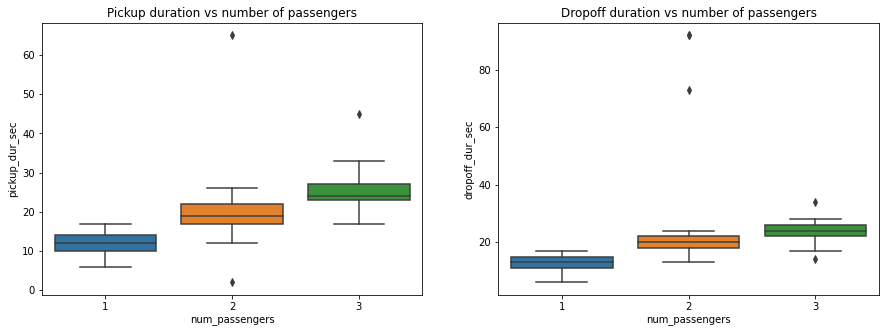

In [18]:
# Plotting the data usin searborn boxplot
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(15,5))
sns.boxplot(ax=axes[0], x= "num_passengers", y= "pickup_dur_sec", data= requests)
axes[0].set_title('Pickup duration vs number of passengers')
sns.boxplot(ax=axes[1], x= "num_passengers", y= "dropoff_dur_sec", data= requests)
axes[1].set_title('Dropoff duration vs number of passengers')
plt.show()

# Conclusion
The boxplot clearly shows that there is a linear relationship between the number of passengers and the time spent during pickup or drop off. It shows that the more passengers there are to pick up or drop off, the more time taken by the vehicle when it stops for these events. There are a few outliners which influenced the mean of the 2 passengers dropoff duration but these are just extreme events which might be caused by some other reasons. 